# MODELISATION DU COMPORTEMENT D'ARBITRAGE EN ASSURANCE VIE

In [1]:
!pip install openpyxl -q
!pip install yahoo_fin --upgrade -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timezone
from yahoo_fin.stock_info import get_data

In [3]:
import os
os.getcwd()

'/home/onyxia/work/Arbitrage_Vie_BNP_Cardif'

In [4]:
base = pd.read_excel("Base_ENSAE_2021_corr.xlsx", sheet_name="Données")

In [5]:
base.head()

,n_sous,Anmois_eff_sous,Anmois_eff_fisc,TOP_2TETE,COD_BEN_DC,COD_BEN_VIE,TOP_BEN_ACPT,MTTC_PRI_REG_ORIG,MT_PRS_VRS_ORIG,MTTC_PRI_INV_ANN,...,PM_UC,PM_FG,montant_corr,NB_UC_corr,montant_frais_corr,mtt_rachat_corr,mtt_vers_corr,mtt_vers_ann_corr,mtt_arbs_corr,mtt_arbe_corr
0,1,197406,197404,0,1,1,0,1281038.83,382235.16,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,197406,197404,0,1,1,0,1281038.83,382235.16,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,197406,197404,0,1,1,0,1281038.83,382235.16,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,197406,197404,0,1,1,0,1281038.83,382235.16,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,197406,197404,0,1,1,0,1281038.83,382235.16,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## ARBITRAGES SUR LE FOND GENERAL

In [6]:
#Base de données des opérations sur le fond Général (toutes les opérations incluant le FG)
base_operation_FG = base.dropna(subset = ['CD_TYPE_SUP'])[base.dropna(subset = ['CD_TYPE_SUP'])['CD_TYPE_SUP'].str.contains('FG')]

#Variables temporelles d'arbitrage (année et mois)
base_operation_FG['annee_operation'] =  base_operation_FG['Anmois_operation'].astype(str).str.slice(0, 4)
base_operation_FG['mois_operation'] =  base_operation_FG['Anmois_operation'].astype(str).str.slice(4, 6)

In [7]:
# regroupement par contrats et par Anmois_operation
base_operation_regroupee_FG = base_operation_FG.groupby(by= ['n_sous', 'Anmois_operation'], as_index = False)

In [8]:
base_operation_FG["operation"].unique()

array(['rachat partiel', 'Arbitrages entrants du FG',
       'Arbitrages sortants du FG', 'primes programmées',
       'rachat programmé', 'décès', 'versement libre', 'PS sur décès',
       'rachat total'], dtype=object)

In [9]:
#Calcul des PM_FG actualisées après chaque opération impliquant le FG
### Pour chaque opération qui inclut le Fond G, on actualise la valeur de la PM après cette opération
base_operation_FG["PM_FG_actualisee"]=np.nan

for (contrat, date), groupe in base_operation_regroupee_FG:
    liste_index = list(groupe.index)
    base_operation_FG.loc[[liste_index[-1]], "PM_FG_actualisee"] = base_operation_FG.loc[[liste_index[-1]], "PM_FG"].values[0] - base_operation_FG.loc[[liste_index[-1]], "montant_corr"].values[0]
    if len(groupe)  >= 2 : # Au cas où il y'a eu au moins deux mouvements concernant le fonds FG
        liste_index.reverse()
        l = len(liste_index)
        for position, i in enumerate(liste_index):
            if position == 0:
                continue
            else:
                for index, ligne in groupe.iterrows():
                    if index == i:
                        montant_operation = ligne['montant_corr']
                        base_operation_FG.loc[[index], "PM_FG_actualisee"] = base_operation_FG.loc[[liste_index[position-1]], "PM_FG_actualisee"].values[0] - montant_operation
        

In [10]:
base_operation_FG[['n_sous','Anmois_operation', 'operation', 'PM_FG','montant_corr','PM_FG_actualisee']].tail(20)

,n_sous,Anmois_operation,operation,PM_FG,montant_corr,PM_FG_actualisee
118914,9458,202112.0,Arbitrages sortants du FG,113235.576015,-5854.02,119089.596015
118955,9463,202109.0,Arbitrages sortants du FG,29281.679346,-9594.17,38875.849346
119072,9473,202110.0,Arbitrages sortants du FG,7124.728836,-3032.88,10157.608836
119084,9475,202105.0,Arbitrages sortants du FG,35387.958173,-1849.08,37237.038173
119147,9480,202106.0,versement libre,2487.687986,2539.80,-52.112014
119226,9488,202101.0,Arbitrages sortants du FG,60670.960189,-3163.69,63834.650189
119228,9488,202103.0,Arbitrages sortants du FG,57705.482418,-3006.55,60712.032418
119397,9502,202104.0,versement libre,42561.833900,17430.00,25131.833900
119467,9507,202101.0,primes programmées,69102.069125,100.00,69002.069125
119468,9507,202102.0,primes programmées,69102.069125,100.00,69002.069125


In [11]:
base_operation_FG[['n_sous','Anmois_operation', 'operation', 'PM_FG','montant_corr','PM_FG_actualisee']].head(20)

,n_sous,Anmois_operation,operation,PM_FG,montant_corr,PM_FG_actualisee
13,2,202102.0,rachat partiel,129737.086302,-12209.33,142139.416302
14,2,202102.0,rachat partiel,129737.086302,-193.00,129930.086302
53,5,202104.0,Arbitrages entrants du FG,10378.395674,10354.23,24.165674
61,5,202111.0,rachat partiel,9214.572337,-1129.03,10343.602337
79,7,202102.0,Arbitrages sortants du FG,0.000000,-24371.62,24371.620000
114,10,202101.0,primes programmées,19721.176295,75.84,19645.336295
115,10,202102.0,primes programmées,19820.853398,75.84,19745.013398
116,10,202103.0,primes programmées,19920.104649,75.84,19844.264649
117,10,202104.0,primes programmées,19983.972725,75.84,19908.132725
118,10,202105.0,primes programmées,20065.856916,75.84,19990.016916


In [12]:
#Base des arbitrages sortants du FG (tous les arbitrages sortant du FG)
base_arbitrage_FG = base_operation_FG.dropna(subset = ['operation'])[base_operation_FG.dropna(subset = ['operation'])['operation'].str.contains('Arbitrages sortants du FG')]
#Base d'arbitrages regroupée
base_arbitrage_regroupee_FG = base_arbitrage_FG.groupby(by= ['n_sous', 'Anmois_operation'], as_index = False)

In [13]:
# Calcul des taux d'arbitrages
base_arbitrage_FG["r_FG"]=0
for (contrat, date), groupe in base_arbitrage_regroupee_FG:
    for index, ligne in groupe.iterrows():
        colonne_operation = ligne['operation']
        if colonne_operation == 'Arbitrages sortants du FG':
            montant_operation = ligne['mtt_arbs_corr'] * (-1)
            base_arbitrage_FG.loc[[index], "r_FG"] = montant_operation/base_arbitrage_FG.loc[[index], "PM_FG_actualisee"].values[0]
            
        

/tmp/ipykernel_471/2466929342.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9956622696078706' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  base_arbitrage_FG.loc[[index], "r_FG"] = montant_operation/base_arbitrage_FG.loc[[index], "PM_FG_actualisee"].values[0]


In [14]:
base_arbitrage_FG.head(20)

,n_sous,Anmois_eff_sous,Anmois_eff_fisc,TOP_2TETE,COD_BEN_DC,COD_BEN_VIE,TOP_BEN_ACPT,MTTC_PRI_REG_ORIG,MT_PRS_VRS_ORIG,MTTC_PRI_INV_ANN,...,montant_frais_corr,mtt_rachat_corr,mtt_vers_corr,mtt_vers_ann_corr,mtt_arbs_corr,mtt_arbe_corr,annee_operation,mois_operation,PM_FG_actualisee,r_FG
79,7,197706,197705,0,1,1,0,288296.01,229853.44,0.00,...,0.0,0.0,0.0,0.0,-24371.62,0.0,2021,02,24371.620000,1.000000
125,10,197803,197802,0,2,1,0,170006.59,9147.35,762.01,...,0.0,0.0,0.0,0.0,-20342.53,0.0,2021,10,20431.154841,0.995662
179,16,197812,197811,0,1,1,0,412297.57,0.00,0.00,...,0.0,0.0,0.0,0.0,-52139.56,0.0,2021,04,522578.280241,0.099774
264,24,197812,197812,0,1,1,0,298930.65,9147.35,0.00,...,0.0,0.0,0.0,0.0,-59695.05,0.0,2021,03,427404.416491,0.139669
272,24,197812,197812,0,1,1,0,298930.65,9147.35,0.00,...,0.0,0.0,0.0,0.0,-29373.86,0.0,2021,09,368138.785935,0.079790
391,34,197912,197912,0,1,1,0,357223.98,0.00,366.90,...,0.0,0.0,0.0,0.0,-30016.89,0.0,2021,06,435285.781450,0.068959
688,58,198112,198112,0,1,1,0,553245.19,180214.05,0.00,...,0.0,0.0,0.0,0.0,-120635.08,0.0,2021,05,549485.086063,0.219542
943,80,198212,198212,0,1,1,0,308445.89,30624.84,0.00,...,0.0,0.0,0.0,0.0,-39413.71,0.0,2021,01,263356.443865,0.149659
947,80,198212,198212,0,1,1,0,308445.89,30624.84,0.00,...,0.0,0.0,0.0,0.0,-29046.33,0.0,2021,03,224007.073352,0.129667
1013,85,198312,198312,0,1,1,0,234492.66,92354.00,35600.59,...,0.0,0.0,0.0,0.0,-7702.57,0.0,2021,07,38710.386307,0.198979


In [15]:
#Mensualisation des taux 
taux_mensuels = pd.DataFrame()
for (contrat, date), groupe in base_arbitrage_regroupee_FG:
    prd_scl = np.dot(groupe["r_FG"], groupe["PM_FG_actualisee"])
    somme = (np.sum(groupe["PM_FG_actualisee"]))
    taux = 1 - (1 - prd_scl/somme)**30
    ligne = pd.DataFrame({'n_sous' : [contrat], 'Anmois_operation' : [int(date)], "r_FG_m" : [taux]})
    taux_mensuels = pd.concat([taux_mensuels, ligne])

In [16]:
base_arbitrage_FG[['n_sous','Anmois_operation', 'operation', 'PM_FG','montant_corr','PM_FG_actualisee', 'r_FG']].head(5)

,n_sous,Anmois_operation,operation,PM_FG,montant_corr,PM_FG_actualisee,r_FG
79,7,202102.0,Arbitrages sortants du FG,0.000000,-24371.62,24371.620000,1.000000
125,10,202110.0,Arbitrages sortants du FG,88.624841,-20342.53,20431.154841,0.995662
179,16,202104.0,Arbitrages sortants du FG,470438.720241,-52139.56,522578.280241,0.099774
264,24,202103.0,Arbitrages sortants du FG,367709.366491,-59695.05,427404.416491,0.139669
272,24,202109.0,Arbitrages sortants du FG,338764.925935,-29373.86,368138.785935,0.079790


In [17]:
#Regroupement de la base des taux mensuels
arbitrage_m_regroupee_FG = taux_mensuels.groupby(by= 'n_sous', as_index = False)

#Annualisation des taux 
taux_annuels = pd.DataFrame()
for contrat, groupe in arbitrage_m_regroupee_FG:
    taux = 1 - (np.prod(1 - groupe["r_FG_m"])) 
    ligne = pd.DataFrame({'n_sous' : [contrat], "r_FG_a" : [taux]})
    taux_annuels = pd.concat([taux_annuels, ligne])

In [18]:
taux_annuels

,n_sous,r_FG_a
0,7,1.000000
0,10,1.000000
0,16,0.957288
0,24,0.999095
0,34,0.882763
...,...,...
0,9458,0.999892
0,9463,0.999797
0,9473,0.999976
0,9475,0.783024


In [19]:
#Fusion des bases pour pouvoir faire correspondre à chaque contrat son taux d'arbitrage mensualisé et annualisé
base_updte = pd.merge(base, taux_mensuels, how="left", on=["n_sous", "Anmois_operation"], suffixes=(None, None))
base_updte = pd.merge(base_updte, taux_annuels, how="left", on="n_sous", suffixes=(None, None))

In [20]:
base_arbitrage_FG[['n_sous','Anmois_operation', 'operation', 'PM_FG','montant_corr','PM_FG_actualisee', 'r_FG']].tail(10)

,n_sous,Anmois_operation,operation,PM_FG,montant_corr,PM_FG_actualisee,r_FG
118905,9458,202107.0,Arbitrages sortants du FG,137793.518750,-7179.02,144972.538750,0.049520
118907,9458,202108.0,Arbitrages sortants du FG,130944.249919,-6822.07,137766.319919,0.049519
118910,9458,202110.0,Arbitrages sortants du FG,124301.254012,-6483.31,130784.564012,0.049572
118912,9458,202111.0,Arbitrages sortants du FG,118247.201094,-6160.55,124407.751094,0.049519
118914,9458,202112.0,Arbitrages sortants du FG,113235.576015,-5854.02,119089.596015,0.049156
118955,9463,202109.0,Arbitrages sortants du FG,29281.679346,-9594.17,38875.849346,0.246790
119072,9473,202110.0,Arbitrages sortants du FG,7124.728836,-3032.88,10157.608836,0.298582
119084,9475,202105.0,Arbitrages sortants du FG,35387.958173,-1849.08,37237.038173,0.049657
119226,9488,202101.0,Arbitrages sortants du FG,60670.960189,-3163.69,63834.650189,0.049561
119228,9488,202103.0,Arbitrages sortants du FG,57705.482418,-3006.55,60712.032418,0.049521


In [21]:
base_arbirtrages_all = base_updte.dropna(subset = ['operation'])[base_updte.dropna(subset = ['operation'])['operation'].str.contains('Arbitrages')]

In [74]:
#Base qui recense tous les arbitrages sortant du FG avec le calcul du taux d'arbitrage annualisé
base_arbitrage_FG_update = base_arbirtrages_all.dropna(subset = ['operation'])[base_arbirtrages_all.dropna(subset = ['operation'])['operation'].str.contains('Arbitrages sortants du FG')]
#Base qui recense tous contrats multi-suppots
base_multisupport = base_updte.dropna(subset = ['support'])[base_updte.dropna(subset = ['support'])['support'].str.contains('Multi-supports avec FG')]
base_multisupport['r_FG_a'] = base_multisupport['r_FG_a'].fillna(0)

In [80]:
base_multisupport['r_FG_a'].nunique()

784

In [23]:
base_no_arbitrages = pd.merge(base_updte, base_arbirtrages_all, how='outer', indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)

In [24]:
base_no_arbitrages["operation"].nunique()

7

In [25]:
#Données sur l'évolution du cours du CAC 40 et du Dow Jones Index en 2021
Cac40_monthly_2021= get_data("^FCHI", start_date="01/01/2021", end_date="12/31/2021", index_as_date = True, interval="1mo")
DJI_monthly_2021= get_data("^DJI", start_date="01/01/2021", end_date="12/31/2021", index_as_date = True, interval="1mo")


In [26]:
#Données sur l'évolution du cours du CAC 40 en 2021
DJI_monthly_2021= get_data("^DJI", start_date="01/01/2021", end_date="12/31/2021", index_as_date = True, interval="1mo")
DJI_monthly_2021

,open,high,low,close,adjclose,volume,ticker
2021-01-01,30627.470703,31272.220703,29856.300781,29982.619141,29982.619141,8168770000,^DJI
2021-02-01,30054.730469,32009.640625,30014.970703,30932.369141,30932.369141,6713920000,^DJI
2021-03-01,31065.900391,33259.000000,30547.529297,32981.550781,32981.550781,9687630000,^DJI
2021-04-01,33054.578125,34256.750000,32985.351562,33874.851562,33874.851562,6810740000,^DJI
2021-05-01,33904.890625,35091.558594,33473.800781,34529.449219,34529.449219,6543360000,^DJI
2021-06-01,34584.191406,34849.320312,33271.929688,34502.511719,34502.511719,6739760000,^DJI
2021-07-01,34507.320312,35171.519531,33741.761719,34935.468750,34935.468750,6646570000,^DJI
2021-08-01,34968.558594,35631.191406,34690.250000,35360.730469,35360.730469,5625700000,^DJI
2021-09-01,35387.550781,35475.398438,33613.031250,33843.921875,33843.921875,6603470000,^DJI
2021-10-01,33930.699219,35892.921875,33785.539062,35819.558594,35819.558594,6709650000,^DJI


In [81]:
#Variables temporelles de signature du contrat(année et mois) et création de la variable "ancienneté"
base_multisupport['annee_sign_sous'] =  base_multisupport['Anmois_sign_sous'].astype(str).str.slice(0, 4)
base_multisupport['mois_sign_sous'] =  base_multisupport['Anmois_sign_sous'].astype(str).str.slice(4, 6)
base_multisupport['annee_sign_sous'] = base_multisupport['annee_sign_sous'].astype(int)
base_multisupport['mois_sign_sous'] = base_multisupport['mois_sign_sous'].astype(int)
base_multisupport['anciennete'] = 2021 - base_multisupport['annee_sign_sous']

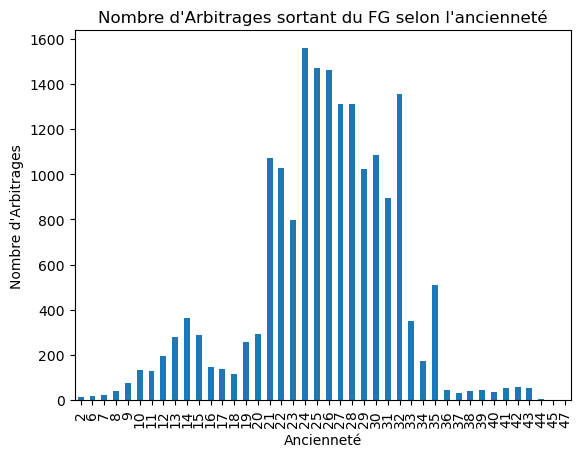

In [82]:
# Groupez par année et comptez le nombre d'arbitrages par année
arbitrages_par_annee = base_multisupport.groupby('anciennete')['operation'].count()

# Créez un graphique (bar, line)
arbitrages_par_annee.plot(kind='bar', xlabel='Ancienneté', ylabel='Nombre d\'Arbitrages', title="Nombre d\'Arbitrages sortant du FG selon l'ancienneté")
plt.show()

/tmp/ipykernel_471/845885954.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='anciennete', y='r_FG_a', data=base_multisupport, palette='Set1', showfliers=False)


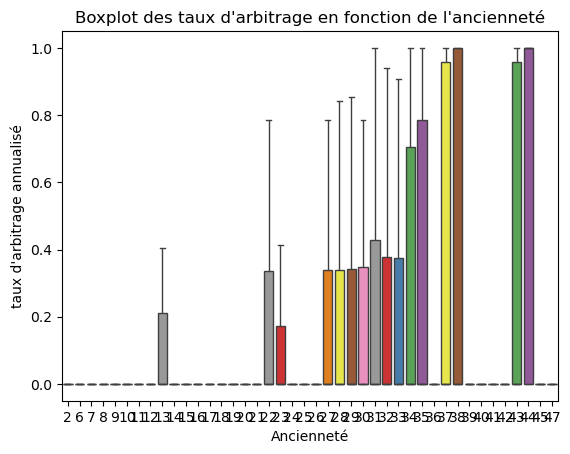

In [85]:
sns.boxplot(x='anciennete', y='r_FG_a', data=base_multisupport, palette='Set1', showfliers=False)
plt.xlabel("Ancienneté")
plt.ylabel("taux d'arbitrage annualisé")
plt.title("Boxplot des taux d'arbitrage en fonction de l'ancienneté")
plt.show()

(array([47488.,    56.,    79.,  3211.,  1040.,   548.,   107.,  1103.,
          591.,  9057.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

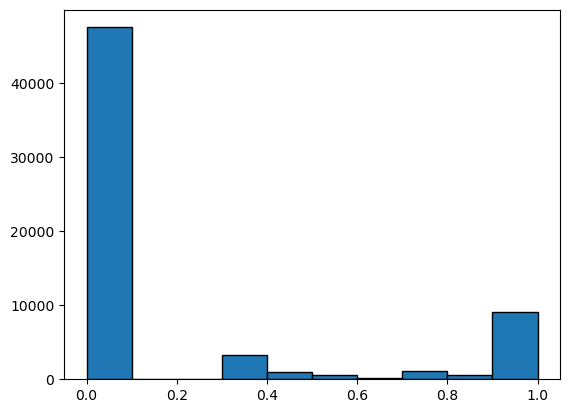

In [90]:
#sns.kdeplot(data=base_multisupport, x='r_FG_a', palette='Set2')
plt.hist(base_multisupport['r_FG_a'], bins=10, edgecolor='black')